In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict

In [ ]:
from google.cloud import storage
import os

# Authenticate
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/path/to/your/service_account.json"  # only if not auto-authenticated

# Access bucket
client = storage.Client()
bucket = client.get_bucket('sutd_ai_project')
blob = bucket.blob('combined_sentiment_data.csv')
blob.download_to_filename('combined_sentiment_data.csv')

In [ ]:
import gcsfs
import pandas as pd

fs = gcsfs.GCSFileSystem()
with fs.open('gs://sutd_ai_project/combined_sentiment_data.csv') as f:
    df2 = pd.read_csv(f)
    df2.columns = ['text', 'sentiment']

Missing values:
text         0
sentiment    0
dtype: int64


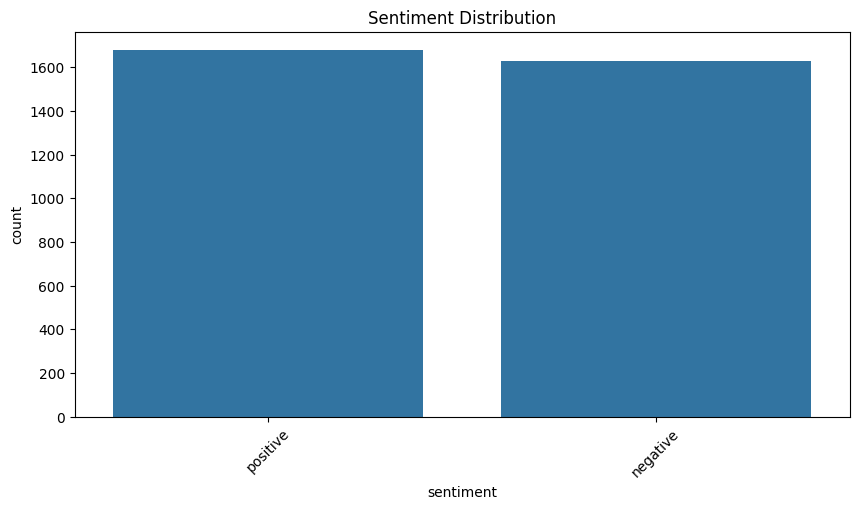

In [ ]:
print("Missing values:")
print(df2.isnull().sum())
df2 = df2.dropna()

plt.figure(figsize=(10,5))
sns.countplot(data=df2, x='sentiment', order=df2['sentiment'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Sentiment Distribution")
plt.show()

In [ ]:
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# Define Singlish lexicon
singlish_lexicon = {
    "shiok": 1.2, "sian": -1.0, "aiyah": -0.3, "aiyo": -0.6, "sabo": -1.2,
    "steady": 0.8, "steady lah": 1.0, "relac": 0.6, "chiong": 0.3, "lepak": 0.7,
    "ang moh": 0.0, "chio": 0.9, "makan": 0.3, "bo jio": -0.6, "paiseh": -0.2,
    "alamak": -0.8, "wah lao": -0.6, "wah piang": -0.6, "lah": 0.1, "leh": 0.1,
    "lor": 0.05, "meh": -0.1, "hor": 0.1, "can lah": 0.5, "no need lah": -0.3,
    "okay lah": 0.5, "don’t play play": 0.3, "jialat": -1.2, "jialat sia": -1.5,
    "heng ah": 0.8, "wah so good": 1.0, "wah so bad": -1.0, "buay tahan": -0.9,
    "shiok sia": 1.0, "win liao lor": 1.0, "confirm plus chop": 0.9, "bo chup": -0.4,
    "act blur": -0.6, "blur like sotong": -0.9, "lim kopi": 0.5, "lim teh": 0.3,
    "catch no ball": -0.3, "don’t anyhow": -0.3, "so stress sia": -1.2,
    "ownself check ownself": -0.5, "talk cock": -0.6, "chio bu": 0.9,
    "ah beng": -0.3, "ah lian": -0.3, "guai kia": 0.6, "kancheong spider": -0.5,
    "spoil market": -0.4, "last warning ah": -0.8
}

# Extract all unique words from df2['text']
unique_words = set()
for text in df2['text']:
    words = text.lower().split()
    unique_words.update(words)

# Compute sentiment score: use Singlish lexicon if available, else VADER
word_sentiment_scores = []
for word in unique_words:
    if word in singlish_lexicon:
        score = singlish_lexicon[word]
    else:
        score = sid.polarity_scores(word)['compound']
    word_sentiment_scores.append({'text': word, 'sentiment_score': score})

# Create final DataFrame
final_df = pd.DataFrame(word_sentiment_scores)

# Optional: sort by score
final_df = final_df.sort_values(by='sentiment_score', ascending=False)

# Show sample
print(final_df.head(10))

              text  sentiment_score
1626     awesome!!           0.6892
5063       great!!           0.6892
2621    amazing!!!           0.6884
6351  delicious!!!           0.6784
4012    perfectly!           0.6696
8160      awesome!           0.6588
5149        great!           0.6588
4992     amazing!!           0.6580
7381   delicious!!           0.6467
5826      paradise           0.6369


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Convert sentiment score to label
def score_to_label(score):
    if score >= 0.05:
        return 2  # positive
    elif score <= -0.05:
        return 0  # negative
    else:
        return 1  # neutral

final_df['label'] = final_df['sentiment_score'].apply(score_to_label)

In [ ]:
# Tokenize text
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

encodings = tokenizer(final_df['text'].tolist(), truncation=True, padding=True)
labels = final_df['label'].tolist()

In [ ]:
# Prepare dataset
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Split
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    final_df['text'], final_df['label'], test_size=0.2, random_state=42)

train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

train_dataset = SentimentDataset(train_encodings, train_labels.tolist())
val_dataset = SentimentDataset(val_encodings, val_labels.tolist())

In [ ]:
# Sentiment label dataset (word-level sentiment via VADER)
print("\n📊 Sentiment Dataset Split Sizes:")
print(f"Train: {len(train_texts)} samples")
print(f"Test: {len(val_texts)} samples")


📊 Sentiment Dataset Split Sizes:
Train: 6675 samples
Test: 1669 samples


In [ ]:
# Train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        for batch in loop:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            # Predictions
            preds = torch.argmax(outputs.logits, dim=1)
            labels = batch['labels']

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        epoch_acc = accuracy_score(all_labels, all_preds)
        print(f"\nEpoch {epoch+1} - Loss: {total_loss:.4f} - Accuracy: {epoch_acc:.4f}\n")

In [ ]:
# Evaluation
def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    target_names = ["negative", "neutral", "positive"]
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=target_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Sentiment Classification - Confusion Matrix")
    plt.show()

In [ ]:
train(model, train_loader, optimizer, epochs=8)

Epoch 1: 100%|██████████| 418/418 [05:56<00:00,  1.17it/s, loss=0.419]



Epoch 1 - Loss: 175.5255 - Accuracy: 0.8602



Epoch 2: 100%|██████████| 418/418 [05:56<00:00,  1.17it/s, loss=0.0925]



Epoch 2 - Loss: 102.8826 - Accuracy: 0.9164



Epoch 3: 100%|██████████| 418/418 [05:56<00:00,  1.17it/s, loss=1.21]



Epoch 3 - Loss: 70.8021 - Accuracy: 0.9432



Epoch 4: 100%|██████████| 418/418 [05:56<00:00,  1.17it/s, loss=0.00162]



Epoch 4 - Loss: 48.8697 - Accuracy: 0.9621



Epoch 5: 100%|██████████| 418/418 [05:56<00:00,  1.17it/s, loss=0.0117]



Epoch 5 - Loss: 32.9843 - Accuracy: 0.9756



Epoch 6: 100%|██████████| 418/418 [05:54<00:00,  1.18it/s, loss=0.00176]



Epoch 6 - Loss: 29.2950 - Accuracy: 0.9775



Epoch 7: 100%|██████████| 418/418 [05:56<00:00,  1.17it/s, loss=0.00154]



Epoch 7 - Loss: 22.9830 - Accuracy: 0.9823



Epoch 8: 100%|██████████| 418/418 [06:07<00:00,  1.14it/s, loss=0.00234]


Epoch 8 - Loss: 19.1212 - Accuracy: 0.9856



Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.75      0.80       130
     neutral       0.94      0.98      0.96      1388
    positive       0.89      0.67      0.76       151

    accuracy                           0.93      1669
   macro avg       0.89      0.80      0.84      1669
weighted avg       0.93      0.93      0.93      1669



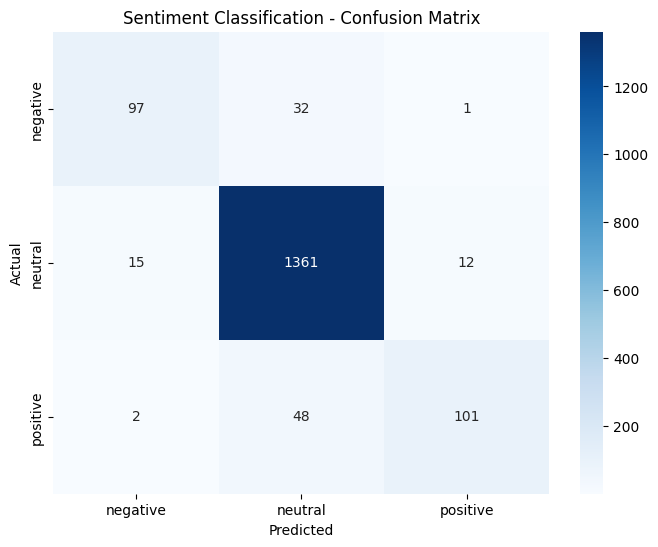

In [ ]:
evaluate(model, val_loader)

In [ ]:
text = "awesome"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    pred = torch.argmax(outputs.logits, dim=1).item()

# Map class ID to label
label_map = {0: "negative", 1: "neutral", 2: "positive"}
print(f"Text: {text}")
print(f"Predicted Sentiment: {label_map[pred]}")

Text: awesome
Predicted Sentiment: positive


In [ ]:
save_dir = "gs://sutd_ai_project/sentiment_roberta_model"
local_model_dir = "/tmp/sentiment_roberta_model"

# Save locally first
model.save_pretrained(local_model_dir)
tokenizer.save_pretrained(local_model_dir)

('/tmp/sentiment_roberta_model/tokenizer_config.json',
 '/tmp/sentiment_roberta_model/special_tokens_map.json',
 '/tmp/sentiment_roberta_model/vocab.json',
 '/tmp/sentiment_roberta_model/merges.txt',
 '/tmp/sentiment_roberta_model/added_tokens.json')

In [ ]:
!gsutil -m cp -r /tmp/sentiment_roberta_model gs://sutd_ai_project/

Copying file:///tmp/sentiment_roberta_model/vocab.json [Content-Type=application/json]...
Copying file:///tmp/sentiment_roberta_model/tokenizer_config.json [Content-Type=application/json]...
Copying file:///tmp/sentiment_roberta_model/special_tokens_map.json [Content-Type=application/json]...
Copying file:///tmp/sentiment_roberta_model/merges.txt [Content-Type=text/plain]...
Copying file:///tmp/sentiment_roberta_model/config.json [Content-Type=application/json]...
Copying file:///tmp/sentiment_roberta_model/model.safetensors [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user 

In [ ]:
!gsutil -m cp -r \
  "gs://sutd_ai_project/sentiment_roberta_model" \
  .

Copying gs://sutd_ai_project/sentiment_roberta_model/config.json...
Copying gs://sutd_ai_project/sentiment_roberta_model/model.safetensors...
Copying gs://sutd_ai_project/sentiment_roberta_model/merges.txt...
Copying gs://sutd_ai_project/sentiment_roberta_model/special_tokens_map.json...
Copying gs://sutd_ai_project/sentiment_roberta_model/tokenizer_config.json...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

Copying gs://sutd_ai_project/sentiment_roberta_model/vocab.json...
\
Operation completed over 6 objects/476.9 MiB.                                    
